In [1]:
import numpy as np
from skimage import io, filters, img_as_ubyte
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import napari

from particle.pipeline import SandHeap

# 1. 加载数据

In [2]:
sandHeap = SandHeap(source="./data/liutao/source1000-1500.npy",
                   se=ndi.generate_binary_structure(rank=3, connectivity=2), 
                   connectivity=1,
                   persistencePath='./data/liutao/',
                   cubeSize=64)
print(sandHeap.data.shape, sandHeap.data.dtype, sandHeap.status)

Function `_loadData` runs for 0h 0min 0.4s
(500, 1766, 1766) uint8 data-loaded


Now plotting the histogram...
Plotting Complete!
data-loaded


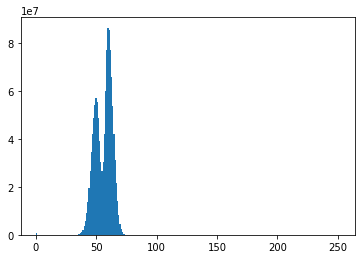

In [3]:
_ = sandHeap.drawHistogram()
print(sandHeap.status)

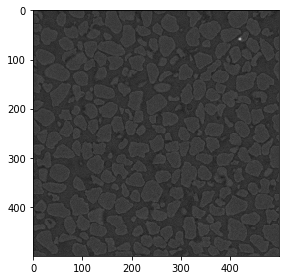

In [4]:
io.imshow(sandHeap.data[250][500:1000, 500:1000])

# 2. 直方图均衡

Now plotting the histogram...
Plotting Complete!
Function `equalizeHist` runs for 0h 0min 54.9s


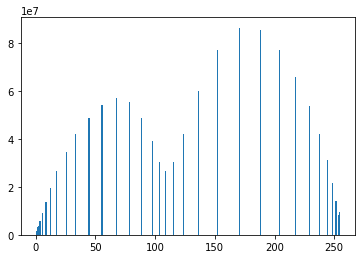

In [5]:
sandHeap.equalizeHist(draw=True)

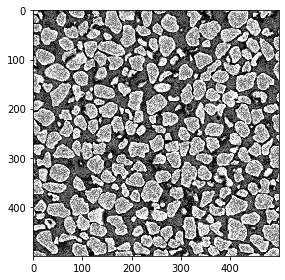

In [6]:
io.imshow(sandHeap.data[250][500:1000, 500:1000])

In [7]:
print(sandHeap.data.shape, sandHeap.data.dtype)

(500, 1766, 1766) uint8


# 3. 中值滤波

In [8]:
# sandHeap.filter(mode="median", cycle=1)
sandHeap.data = np.load('./data/liutao/v1/filtered.npy')
sandHeap.setStatus("filtered")

Now plotting the histogram...
Plotting Complete!


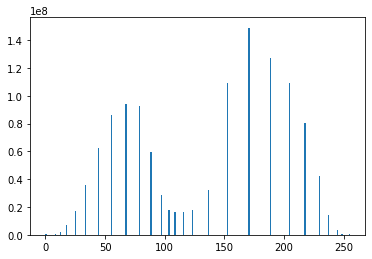

In [9]:
_ = sandHeap.drawHistogram()

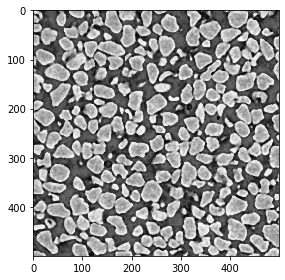

In [10]:
io.imshow(sandHeap.data[250][500:1000, 500:1000])

# 4. 二值化分割

In [11]:
grayThrd = filters.threshold_otsu(sandHeap.data[sandHeap.circleMask], nbins=255)
grayThrd

123

Function `binarySegmentation` runs for 0h 0min 4.2s


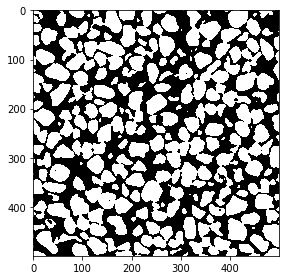

In [12]:
sandHeap.binarySegmentation(threshold=grayThrd)
io.imshow(img_as_ubyte(sandHeap.data[250][500:1000, 500:1000]))

In [13]:
np.save('./data/liutao/binary-thrd.npy', sandHeap.data)

# 5. 开运算

Function `binaryOpening` runs for 0h 0min 40.5s


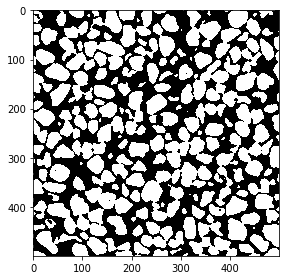

In [14]:
sandHeap.binaryOpening()
io.imshow(img_as_ubyte(sandHeap.data[250][500:1000, 500:1000]))

In [15]:
np.save('./data/liutao/binary-open.npy', sandHeap.data)

# 6. 孔洞填充

Function `binaryFillHoles` runs for 0h 1min 29.8s


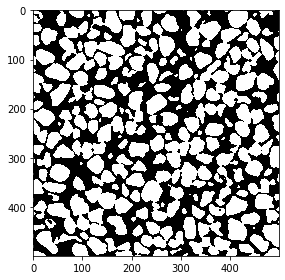

In [16]:
sandHeap.binaryFillHoles()
io.imshow(img_as_ubyte(sandHeap.data[250][500:1000, 500:1000]))

In [17]:
np.save('./data/liutao/binary-fill.npy', sandHeap.data)

# 7. 分水岭分割

## 7.1. 距离变换

Function `_distanceForWatershed` runs for 0h 0min 34.6s


/opt/miniconda3/envs/PyTorch/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


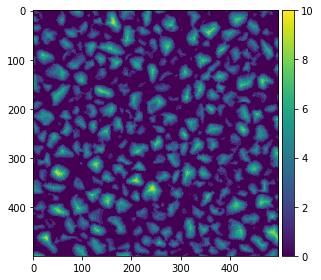

In [18]:
sandHeap._distanceForWatershed(mode="cdt", metric="chessboard", persistence=True)
# sandHeap._distanceForWatershed(mode="edt", pinch=True, persistence=True)
io.imshow(sandHeap._distance[250][500:1000, 500:1000])

## 7.2. 获取种子点

Function `_markersForWatershed` runs for 0h 4min 39.4s


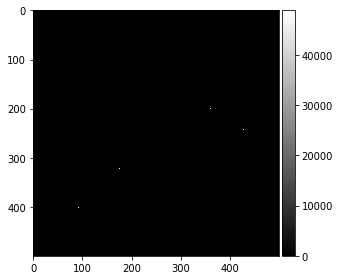

In [19]:
sandHeap._markersForWatershed(min_distance=7, persistence=True)
io.imshow(sandHeap._markers[250][500:1000, 500:1000], cmap="gray")

## 7.3. 分割

After preliminary watershed-segmentation, found 96090 regions.
Function `watershedSegmentation` runs for 0h 50min 53.8s


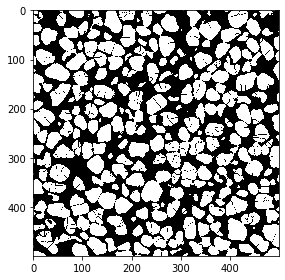

In [20]:
sandHeap.watershedSegmentation(min_distance=7, persistence=True)
io.imshow(img_as_ubyte(sandHeap.preSegmented[250][500:1000, 500:1000]))

# 8. 分割优化 

The pre-segmented image has initially 152444 segmentation faces.
24413 segmentation faces will be removed!
Removal completes!
Function `removeBigSegmentationFace` runs for 0h 0min 27.6s


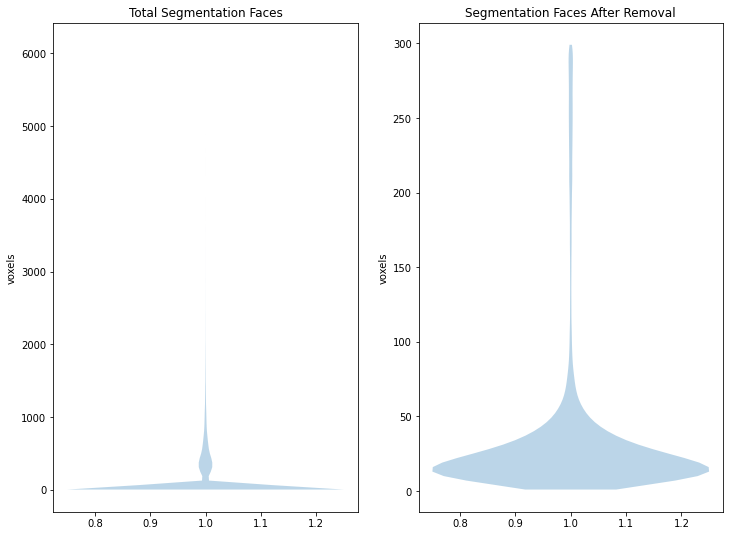

In [21]:
_ = sandHeap.removeBigSegmentationFace('3d', threshold=300, connectivity=2, persistence=True, returnDiagram=True)

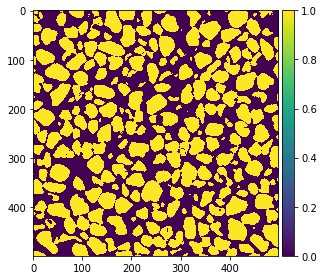

In [22]:
io.imshow(img_as_ubyte(sandHeap.finalSegmented[250][500:1000, 500:1000]))

In [23]:
preLabeled, num = ndi.label(sandHeap.preSegmented)
print(num)

96090


In [ ]:
finalLabeled, num = ndi.label(sandHeap.finalSegmented)
print(num)

21466
